![NeuronUnit Logo](https://raw.githubusercontent.com/scidash/assets/master/logos/neuronunit.png)
# Chapter 3
Back to [Chapter 2](chapter2.ipynb)

In the second chapter we tested a real ion channel model using data from the [OpenWorm](http://openworm.org) project.  Here we'll test a neuron model using data from the [NeuroElectro](http://neuroelectro.org) project.  
### We'll test the resting potential and action potential width of a couple of cerebellar granule cell models.  

In [1]:
import os
import quantities as pq
import sciunit
from neuronunit import tests,capabilities
from neuronunit import neuroelectro # This module allows interaction with NeuroElecto through a REST API.  

In this example, we'll use models downloaded from [Open Source Brain](http://www.opensourcebrain.org) and run via [neuroConstruct](http://www.neuroconstruct.org) using [execnet](http://codespeak.net/execnet).

In [2]:
import neuronunit.neuroconstruct.models as nc_models # Model classes for use with neuroConstruct 
                                                     # (http://www.neuroconstruct.org), a model and 
                                                     # simulation manager for detailed neuron models.  
from pythonnC.utils.putils import OSB_MODELS # Path to models downloaded from Open Source Brain.

# We will test cerebellar granule cell models.  
brain_area = 'cerebellum'
neuron_type = 'cerebellar_granule_cell'
neuron_type_path = os.path.join(OSB_MODELS,brain_area,neuron_type)

We will look up data for cerebellar granule cells by [NeuroLex](http://neurolex.org) ID to make sure we get an unambiguous neuron type.<br>
You can browse [NeuroLex](http://neurolex.org) to find your favorite neuron type.

In [3]:
neurolex_id = 'nifext_128' # Cerebellar Granule Cell

### Now we instantiate two tests parameterized by data retrieved on the fly from [NeuroElectro](http://neuroelectro.org).
One for resting membrane potential:

In [4]:
# Specify reference data for a test of resting potential for a granule cell.  
reference_data = neuroelectro.NeuroElectroSummary(
    neuron = {'nlex_id':neurolex_id}, # Neuron type lookup using the NeuroLex ID.  
    ephysprop = {'name':'Resting Membrane Potential'}) # Ephys property name in the NeuroElectro ontology. 
reference_data.get_values() # Get and verify summary data for the combination above from neuroelectro.org. 

rmp_test = tests.RestingPotentialTest(
                observation = {'mean':reference_data.mean*pq.mV, # In millivolts.  
                               'std':reference_data.std*pq.mV},
                name = 'Resting Potential')

Getting data values from neuroelectro.org
http://www.neuroelectro.org/api/1/nes/?e__name=Resting+Membrane+Potential&nlex=nifext_128


And one for action potential width:

In [5]:
# Specify reference data for a test of action potential width.  
reference_data = neuroelectro.NeuroElectroSummary(
    neuron = {'nlex_id':neurolex_id}, # Neuron type lookup using the NeuroLex ID.  
    ephysprop = {'name':'Spike Half-Width'}) # Ephys property name in the NeuroElectro ontology. 
reference_data.get_values() # Get and verify summary data for the combination above from neuroelectro.org. 

spikewidth_test = tests.InjectedCurrentSpikeWidthTest(
                observation = {'mean':reference_data.mean*pq.ms, # In milliseconds.  
                               'std':reference_data.std*pq.ms},
                name = 'Spike Width',
                params={'injected_current':{'ampl':0.006}}) # 0.0053 nanoamps of injected current.  

Getting data values from neuroelectro.org
http://www.neuroelectro.org/api/1/nes/?e__name=Spike+Half-Width&nlex=nifext_128


### Let's create a test suite to group these two tests of a granule cell's properties.  

In [6]:
# Create a test suite from these two tests.  
suite = sciunit.TestSuite('Neuron Tests',(spikewidth_test,rmp_test))

### Tests and tests suites can be executed against single models or lists of model.  
Let's instantiate a few different granule cell models and add them to a list to be tested.<br>
Each of them is already parameterized in corresponding [NeuroML](http://neuroml.org) files associated with the [Open Source Brain](http://opensourcebrain.org) project.  

In [7]:
model_names = ['GranuleCell','cereb_grc_mc'] # The names of two granule cell models 
                                             # available at http://opensourcebrain.org.
models = [] # Our list of models to be tested.  
for model_name in model_names:
    model_info = (brain_area,neuron_type,model_name) # Information about each model.  
    model = nc_models.OSBModel(*model_info) # Instantiate a model using that information.  
    models.append(model) # Add to the list of models to be tested.  

### Run each test against each model.  

In [8]:
# Running these 2 tests against these 2 models means 4 total simulations.  
score_matrix = suite.judge(models,stop_on_error=True) 

Running simulation...
Running simulation...
Running simulation...
Running simulation...


/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/quantities/quantity.py:379: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return self.magnitude == other


### Display the results as a table.
The 'cereb_grc_mc' model doesn't seem to spike, so there is insufficient data to produce a score.

In [9]:
score_matrix.view()

,Spike Width (InjectedCurrentSpikeWidthTest),Resting Potential (RestingPotentialTest)
GranuleCell (OSBModel),Z = 24.80,Z = 0.89
cereb_grc_mc (OSBModel),InsufficientDataScore(None),Z = 1.10


### Plot some of the model output that led to those scores:

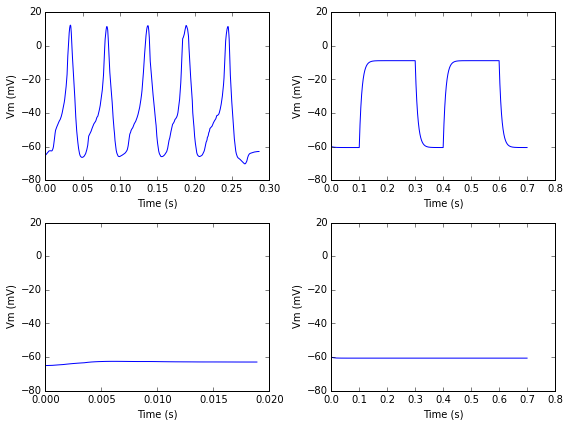

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
fig,ax = plt.subplots(2,2,figsize=(8,6)) # Create plot windows.  
for i,test in enumerate(score_matrix.tests): # For each test...
    for j,model in enumerate(score_matrix.models): # And each model...
        score = score_matrix[test,model] # Get the score.  
        score.plot_vm(ax[i,j]) # And use a convenience method to plot the membrane potential.  
fig.tight_layout() # Space the plots nicely. 